## Un réseau MLP pour la classification en dimension 2

Construit avec PyTorch, ce réseau va associer les coordonnées $(x, y)$ d'un point du plan à une classe.

On va chercher à séparer les exemples de 4 classes (numérotées de 0 à 3).

Le premier modèle, linéaire, permetra de se roder. On construira ensuite un réseau MLP avec deux couches cachées:
 * rétine de 2 neurones ($(x,y)$)
 * une couche linéaire + ReLu avec N1 neurones
 * une autre identique avec N2 neurones
 * une couche de sortie avec un neurone par class
 
On utilisera comme coût l'entropie croisée (`CrossEntropyLoss`). 


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

## Les données
On lit un fichier CSV qui contient 3 colonnes: $(x, y, c)$ où $c \in \{0, 1, 2, 3\}$ indique la classe du point $(x,y)$.

                0           1          2
count  200.000000  200.000000  200.00000
mean     3.119035   -0.382835    1.50000
std      5.395644    3.137519    1.12084
min     -6.874860   -7.075802    0.00000
25%      0.311461   -2.922907    0.75000
50%      4.256648   -0.710461    1.50000
75%      6.582249    2.412043    2.25000
max     11.359325    5.753062    3.00000
Nombre d'exemple 200
Nombre de classes: 4


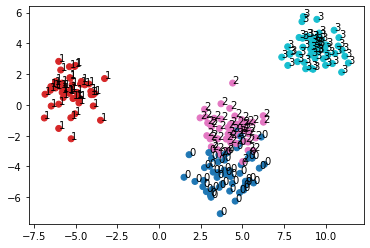

In [2]:
# Les données
# Données : lecture d'un fichier CSV (créé par 00-gen2Ddata.ipynb)
D = pd.read_csv('kms-dataset2d-XY.csv', sep=';', header=None)
print(D.describe())
data = np.array(D)
X = data[:,:2]
y = data[:,2].astype(np.int64)
N = X.shape[0]
print("Nombre d'exemple", N)
NbClass = len(np.unique(y)) # nombre de classes à discriminer
print("Nombre de classes:", NbClass)

# Affiche les données
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.get_cmap('tab10'))
for i, txt in enumerate(y):
    plt.annotate(txt, (X[i,0], X[i,1]))
plt.show()

Noter que les classes 0 et 2 se recouvrent.

In [3]:
# Mise en forme des données
# from_numpy donne un Tenseur à partir d'un tableau numpy
x_data = torch.Tensor(X)
y_data = torch.from_numpy(y)
print(y.dtype)
print(y_data.dtype)

int64
torch.int64


## Un modèle linéaire

Ce modèle comporte une couche, `nn.Linear`, et 4 cellules de sortie. Chaque cellule de sortie calcule donc un produit scalaire entre l'entrée et ses poids.

La plus active indiquera la classe donnée par ce réseau.

In [4]:
class ModeleLineaire(nn.Module):
    def __init__(self):
        super(ModeleLineaire, self).__init__()
        self.couche_lineaire = nn.Linear(2, NbClass)
    
    def forward(self, x):
        x = self.couche_lineaire(x)
        return x

modele = ModeleLineaire()

In [5]:
# Le critère à optimiser (coût)
criterion = nn.CrossEntropyLoss()
# L'algorithme d'optimisation: 
optimizer = torch.optim.SGD(modele.parameters(), lr=0.01, momentum=0.9)

0.19321350753307343


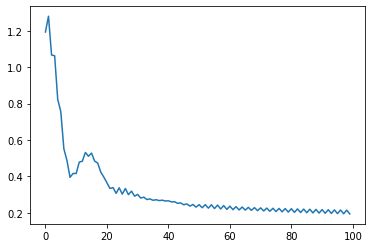

In [6]:
# Boucle d'apprentissage
batch_size = 100
num_epochs = 50

losses = []
for epoch in range(num_epochs):
    for beg_i in range(0, x_data.size(0), batch_size):
        x_batch = x_data[ beg_i:beg_i + batch_size, :]
        y_batch = y_data[ beg_i:beg_i + batch_size]
        # remise à zéro des gradients
        optimizer.zero_grad()
        # forward:
        outputs = modele(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

plt.plot(losses)
print(losses[-1])

### Matrice de confusion (classification)
Une matrice de confusion permet de visualiser les erreurs d'un classifieur: la cellule $(i, j)$ donne le nombre d'exemples appartenant à la classe $i$ et classés par le modèle comme étant de la classe $j$.

On va s'en servir plusieurs fois, aussi nous définissons une fonction:

In [7]:
# Matrice de confusion, construite à la main
# CM[b,c] = nombre d'exemples de la classe b classés dans la classe c

def matrice_de_confusion( y, y_pred ):
    # y et y_pred sont des vecteurs avec des indices de classes (0, .., nbClass)
    NbClass = len(np.unique(y)) # nombre de classes
    CM = np.zeros((NbClass,NbClass))
    # ici la classe predite est donnée par le max de la sortie
    for i in range(len(x_data)):
        real_class = y[i]
        pred_class = np.argmax(y_pred[i])
        #print("real", real_class, "predicted", pred_class)
        CM[real_class, pred_class] += 1
    return CM

# Calcule les sorties prévues
# et les converti en tableau numpy
y_pred = modele(x_data).detach().numpy()

CM = matrice_de_confusion(y, y_pred)
print(CM)

[[44.  0.  6.  0.]
 [ 0. 50.  0.  0.]
 [ 7.  0. 42.  1.]
 [ 0.  0.  0. 50.]]


## Questions:
(répondre à chaque question dans une cellule différente)
* Quelle classe est confondue avec quelle autre ?
* Combien d'exemples sont-ils mal classés en tout ? Taux d'erreur en pourcentage ?
* Quelle est la dernière valeur mesirée du coût ?
* Si on augmente le nombre de passes (epochs), le coût diminue-t-il ? Est-ce que cela améliore la matrice de confusion ?


## Un réseau de neurones

Notre deuxième modèle comporte deux couches cachées, avec des activations non-linéaires de type ReLu.

Le nombre de cellules par couche est donc:

`2 -> N1 -> N2 -> NbClass`

Ici `N1 = 2, N2 = 3`.


Le constructeur `__init__` crée 3 couches linéaires, utilisées dans la méthode `forward`. 

In [8]:
# Le modèle:  (on fera varier les valeurs de N1 et N2)
N1 = 2
N2 = 3

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, N1)
        self.fc2 = nn.Linear(N1, N2)
        self.fc3 = nn.Linear(N2, NbClass)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [9]:
# Le critère à optimiser (coût)
criterion = nn.CrossEntropyLoss()
# L'algorithme d'optimisation: 
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

0.4761906564235687


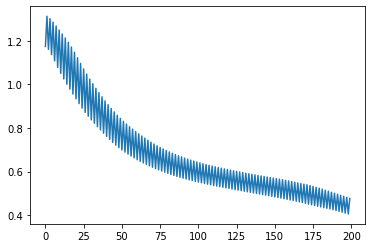

In [10]:
# Boucle d'apprentissage
batch_size = 100
num_epochs = 100

losses = []
for epoch in range(num_epochs):
    for beg_i in range(0, x_data.size(0), batch_size):
        x_batch = x_data[ beg_i:beg_i + batch_size, :]
        y_batch = y_data[ beg_i:beg_i + batch_size]
        # remise à zéro des gradients
        optimizer.zero_grad()
        # forward:
        outputs = net(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

plt.plot(losses)
print(losses[-1])

In [11]:
# Matrice de confusion
y_pred = net(x_data).detach().numpy()

CM = matrice_de_confusion(y, y_pred)
print(CM)

[[26. 11. 13.  0.]
 [ 0. 50.  0.  0.]
 [ 6.  0. 43.  1.]
 [ 0.  0.  0. 50.]]


## Questions
* Quelle est la dernière valeur du coût ?
* Quelles sont les classes confondues ?
* Combien d'erreurs ? Taux en pourcentage ?
* Tenter d'améliorer le modèle: varier N1 et N2. Pour chaque configuration, relever la valeur du coût, les nombres et taux d'erreurs de classification. Quelle est votre architecture optimale ?

### Questions subsidiaires
* Pour le modèle linéaire, extraire les poids et tracer les frontières sur le graphique 2d.
* Essayer d'autres modèles classiques: kNN, logistique, SVM, et comparer les résultats.